In [6]:
# Basic set up and load dataset

import pandas as pd
import os

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


PATH_DATA_IN = r'G:\My Drive\MasterThesis\Data\Meli\Clean\CABA\Alquiler'
PATH_DATA_OUT = r'G:\My Drive\MasterThesis\Output'
# PATH_DATA_IN = r'H:\My Drive\MasterThesis\Data\Meli\Clean\CABA\Alquiler'
# PATH_DATA_OUT = r'H:\My Drive\MasterThesis\Output'

# Download data
path = os.path.join(PATH_DATA_IN, "meli_clean_alquiler_2018_2022.csv")
df = pd.read_csv(path)

# Convert the 'listing_month' column to datetime format
df['listing_month'] = pd.to_datetime(df['listing_month'])

# Encode neighbourhood variables
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df['neighbourhood'])
one_hot.columns = ['nei_' + col.replace(' ', '_').lower() for col in one_hot.columns]
df = df.join(one_hot)

df['commune'] = df['commune'].replace('COMUNA', 'commune', regex=True)
one_hot = pd.get_dummies(df['commune'], drop_first=True)
one_hot.columns = [col.replace(' ', '_').lower() for col in one_hot.columns]
df = df.join(one_hot)

DEP_VAR = ['price_realpesos']
INDEP_VARS = ['house', 
              'covered_area', 'uncovered_area', 'bedrooms', 'bathrooms', 
       'pool', 'security', 'furnished', 'heating', 'air_conditioning',
       'parking', 'common_space', 'fitness_space',
       'distance_to_transport', 'distance_to_greenspace',
       # 'longitude', 'latitude', 
       'month'] + [col for col in df if col.startswith('nei_')]
# Distance to CBD se va porque es muy colineal con longitud

df.head()

,id,listing_month,commune,house,neighbourhood,listing_type,listing_age,year,semester,quarter,month,price_realpesos,price_usd,price_realpesos_per_covered_sqm,price_usd_per_covered_sqm,invoiced_in_usd,total_area,covered_area,uncovered_area,bedrooms,bathrooms,rooms,property_age,pool,security,furnished,heating,air_conditioning,parking,common_space,fitness_space,distance_to_transport,distance_to_greenspace,distance_to_cbd,longitude,latitude,nei_agronomia,nei_almagro,nei_balvanera,nei_barracas,nei_belgrano,nei_boca,nei_boedo,nei_caballito,nei_chacarita,nei_coghlan,nei_colegiales,nei_constitucion,nei_flores,nei_floresta,nei_liniers,nei_mataderos,nei_monserrat,nei_monte_castro,nei_nueva_pompeya,nei_nunez,nei_palermo,nei_parque_avellaneda,nei_parque_chacabuco,nei_parque_chas,nei_parque_patricios,nei_paternal,nei_puerto_madero,nei_recoleta,nei_retiro,nei_saavedra,nei_san_cristobal,nei_san_nicolas,nei_san_telmo,nei_velez_sarsfield,nei_versalles,nei_villa_crespo,nei_villa_del_parque,nei_villa_devoto,nei_villa_gral._mitre,nei_villa_lugano,nei_villa_luro,nei_villa_ortuzar,nei_villa_pueyrredon,nei_villa_real,nei_villa_riachuelo,nei_villa_santa_rita,nei_villa_soldati,nei_villa_urquiza,commune_10,commune_11,commune_12,commune_13,commune_14,commune_15,commune_2,commune_3,commune_4,commune_5,commune_6,commune_7,commune_8,commune_9
0,702933219,2018-01-01,commune 1,0,CONSTITUCION,ALQUILER,13,2018,1,1,1,88452.092588,513.897409,2764.127893,16.059294,0,32,32,0,1,1,1,1.0,0,0,0,0,1,0,1,0,237.485276,782.266376,1602.363718,-58.384193,-34.617988,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,698281355,2018-02-01,commune 1,0,CONSTITUCION,ALQUILER,74,2018,1,1,2,69788.237176,406.389344,1073.665187,6.252144,0,65,65,0,2,1,3,50.0,0,0,0,0,0,0,0,0,599.783773,411.387370,2841.485500,-58.387475,-34.628829,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,696559219,2018-01-01,commune 1,0,CONSTITUCION,ALQUILER,52,2018,1,1,1,107214.657682,622.905951,1429.528769,8.305413,0,79,75,4,3,2,4,20.0,0,0,0,0,0,0,0,0,900.364426,265.997915,3286.982991,-58.389738,-34.632526,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,700922513,2018-01-01,commune 1,0,CONSTITUCION,ALQUILER,25,2018,1,1,1,116149.212489,674.814780,3226.367014,18.744855,0,40,36,4,1,1,1,0.0,1,1,1,1,1,0,1,1,335.551581,751.431511,1917.516714,-58.387964,-34.620156,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,704907347,2018-01-01,commune 1,0,CONSTITUCION,ALQUILER,2,2018,1,1,1,71476.438455,415.270634,1520.775286,8.835545,0,47,47,0,1,1,2,0.0,0,0,0,0,0,0,0,0,357.911737,293.744309,2909.308282,-58.384171,-34.629822,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
# Select best parameters using only the year 2018 and Random CV


param_grid = [

    # Leraning
    {'learning_rate': [0.01, 0.1, 0.15, 0.3],
    'n_estimators' : [50, 100, 200, 300],

    # Tree
    'min_child_weight': [1, 3, 5, 7],
    'max_depth': [3, 5, 7, 9]}, # separate

    # Tree
    {'gamma': [0, 0.1, 0.2, 0.4],

    'colsample_bytree': [0.5, 0.75, 0.9, 1],

    # Regularization
    'reg_alpha':[0, 1, 50, 100]}
    
]

import estimate_xgboost
import importlib
importlib.reload(estimate_xgboost)


result = estimate_xgboost.estimate_xgb(
                                df=df,
                                sample_df=False,
                                # sample_df=10000,

                                starting_month=0,
                                ending_month=13,

                                DEP_VAR=DEP_VAR, 
                                INDEP_VARS=INDEP_VARS,

                                tune_hyperparams=True,
                                parameter_grid=param_grid,
                                cv_strategy='random_cv',

                                time_window_size=12,

                                save_model_path=os.path.join(PATH_DATA_OUT, 'Models'),
                                # save_model_path=False,

                                verbose=3,                                
                                )

Starting estimation for month: 2019-01 

Training sample goes from 2018-01 to 2018-12
Best parameters from round 1: {'learning_rate': 0.15, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 300}
Best parameters from round 2: {'colsample_bytree': 1, 'gamma': 0, 'reg_alpha': 50, 'subsample': 0.9}
Time taken for month 2019-01: 858.94 seconds

Total execution time: 858.99 seconds


In [31]:
# Show best parameters found
import joblib
import os
best_params_path = os.path.join(PATH_DATA_OUT, 'Models', 'tuned', 'random_cv_winsize12_sampleFalse_2019-01.pkl')
saved_model = joblib.load(best_params_path)
best_params = saved_model.get_params()
best_params

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 50,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.9,
 'tree_method': 'exact',
 'validate_parameters': None,
 'verbosity': None,
 'seed': 789}

In [10]:
# Experiment 4: using previously calibrated hyperparameters (with neighbourhoods)

import estimate_xgboost
import importlib
importlib.reload(estimate_xgboost)

for w_size in [False, 1, 3, 6, 12, 24]:
    print(f'Estimating model for window size {w_size} \n \n')

    result = estimate_xgboost.estimate_xgb(
                                df=df,
                                sample_df=False,

                                DEP_VAR=DEP_VAR, 
                                INDEP_VARS=INDEP_VARS,

                                tune_hyperparams=False,
                                best_params_path=os.path.join(PATH_DATA_OUT, 'Models', 'tuned', 
                                                              'random_cv_winsize12_sampleFalse_2019-01.pkl'),

                                time_window_size=w_size,

                                save_model_path=os.path.join(PATH_DATA_OUT, 'Models', 'with_neighbourhoods'),

                                verbose=3,   
                                    )

    # Save result as csv
    path_ = os.path.join(PATH_DATA_OUT, 'Tables', 'EstimationResults', 'TrainingStage', f'exp4{w_size}_notuning.csv')
    result.to_csv(path_)


Estimating model for window size False 
 

Starting estimation for month: 2018-02 

Training sample goes from 2018-01 to 2018-01
Time taken for month 2018-02: 0.23 seconds

Starting estimation for month: 2018-03 

Training sample goes from 2018-01 to 2018-02
Time taken for month 2018-03: 0.19 seconds

Starting estimation for month: 2018-04 

Training sample goes from 2018-01 to 2018-03
Time taken for month 2018-04: 0.25 seconds

Starting estimation for month: 2018-05 

Training sample goes from 2018-01 to 2018-04
Time taken for month 2018-05: 0.28 seconds

Starting estimation for month: 2018-06 

Training sample goes from 2018-01 to 2018-05
Time taken for month 2018-06: 0.33 seconds

Starting estimation for month: 2018-07 

Training sample goes from 2018-01 to 2018-06
Time taken for month 2018-07: 0.39 seconds

Starting estimation for month: 2018-08 

Training sample goes from 2018-01 to 2018-07
Time taken for month 2018-08: 0.44 seconds

Starting estimation for month: 2018-09 

Traini

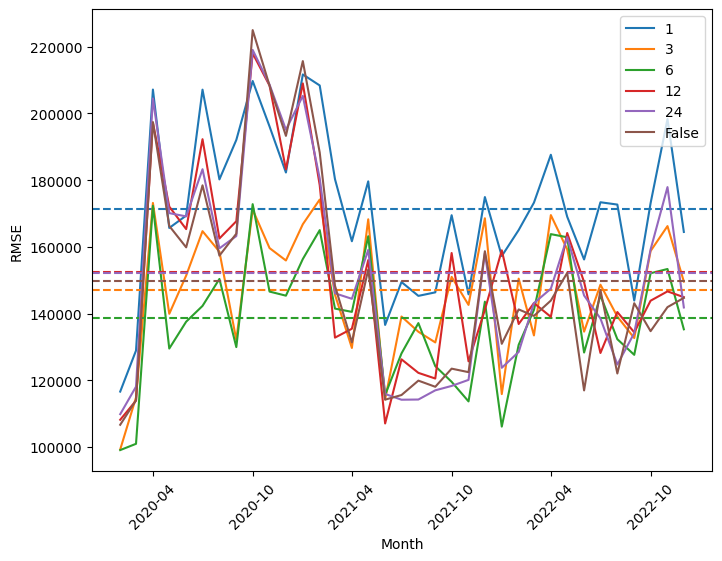

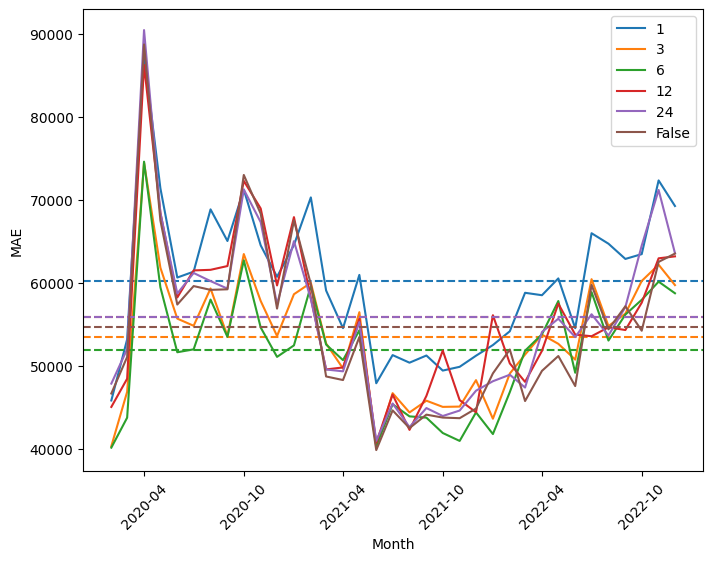

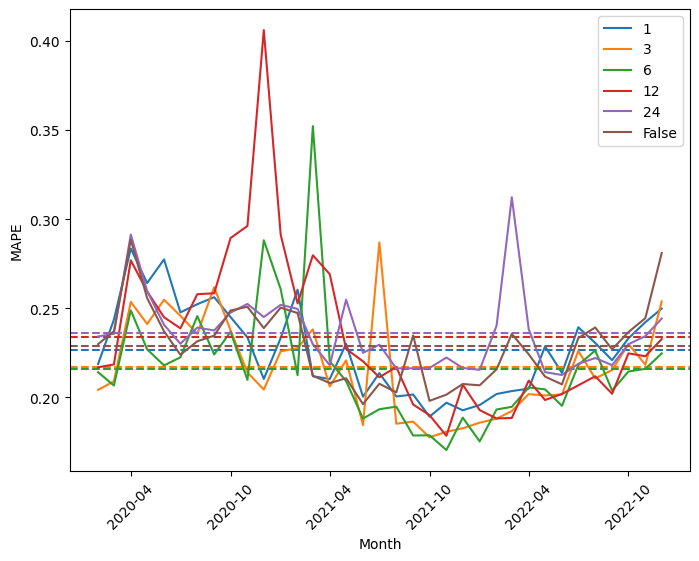

In [14]:
# Plots: experiment 4 (tuning in 2018), plot results for different window sizes

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

path_ = r'G:\My Drive\MasterThesis\Output\Tables\EstimationResults\TrainingStage'
w_sizes = [1, 3, 6, 12, 24, False]
error_metrics = ['rmse', 'mae', 'mape']

for em in error_metrics:

    # Initialize an empty dictionary to store the data frames with the results
    results_dfs = {}

    for ws in w_sizes:

        # Read df
        res_df = pd.read_csv(path_ + f'\exp4{ws}_notuning.csv', index_col=0)

        # Rename columns
        res_df = res_df.rename(columns={col: f'{col}_exp4{ws}' for col in res_df.columns if col != 'month'})

        # Save into data frame
        results_dfs[f'res_{ws}'] = res_df
        del res_df

    # Merge data frames together
    results = results_dfs['res_1']
    for ws in w_sizes[1:]:

        results = results.merge(results_dfs[f'res_{ws}'], how='left', on=['month'])

    results['month'] = pd.to_datetime(results['month'])
    results = results[results['month'] >= pd.Timestamp('2020-02-01')]
    # results.head()

    # Make plot
    plt.figure(figsize=(8, 6))
    ax = plt.gca()

    for ws in w_sizes:
        color = next(ax._get_lines.prop_cycler)['color']
        plt.plot(results['month'], results[str(em)+'_exp4'+str(ws)], label=ws, color=color)
        plt.axhline(y = results[str(em)+'_exp4'+str(ws)].mean(), linestyle = '--', label='', color=color)

    plt.xlabel('Month')
    plt.ylabel(em.upper())
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.legend(loc="upper right")

    # Save plot
    if True:
        path_p = os.path.join(PATH_DATA_OUT, 'Plots', 'EstimationResults', 'TrainingStage', 
                             'Experiment_4', f'{em}.png')
        plt.savefig(path_p, dpi=300)  # Save as PNG with high resolution


    plt.show()

In [34]:
# Experiment 3 - Ensemble with equal weights

import ensemble_model
import importlib
importlib.reload(ensemble_model)

w_sizes = [1, 3, 6, 12, 24]

result = ensemble_model.run_ensemble(
                        df=df,
                        sample_df=False,

                        DEP_VAR=DEP_VAR, 
                        INDEP_VARS=INDEP_VARS,

                        equal_weights=True,
                        time_window_sizes=w_sizes,

                        path_to_error_metrics=os.path.join(PATH_DATA_OUT, 'Tables',
                                                    'EstimationResults', 'TrainingStage'),
                        path_to_models=os.path.join(PATH_DATA_OUT, 'Models', 'not_tuned'),

                        verbose=3,   
                        )

# Save result as csv
path_ = os.path.join(PATH_DATA_OUT, 'Tables', 'EstimationResults', 'TrainingStage', f'exp3ensemble_equalw_notuning.csv')
result.to_csv(path_)

Starting estimation for month: 2020-01 

Starting estimation for month: 2020-02 

Starting estimation for month: 2020-03 

Starting estimation for month: 2020-04 

Starting estimation for month: 2020-05 

Starting estimation for month: 2020-06 

Starting estimation for month: 2020-07 

Starting estimation for month: 2020-08 

Starting estimation for month: 2020-09 

Starting estimation for month: 2020-10 

Starting estimation for month: 2020-11 

Starting estimation for month: 2020-12 

Starting estimation for month: 2021-01 

Starting estimation for month: 2021-02 

Starting estimation for month: 2021-03 

Starting estimation for month: 2021-04 

Starting estimation for month: 2021-05 

Starting estimation for month: 2021-06 

Starting estimation for month: 2021-07 

Starting estimation for month: 2021-08 

Starting estimation for month: 2021-09 

Starting estimation for month: 2021-10 

Starting estimation for month: 2021-11 

Starting estimation for month: 2021-12 

Starting estimat

In [35]:
# Experiment 3 - Ensemble with weights according to performance in previous month

import ensemble_model
import importlib
importlib.reload(ensemble_model)

w_sizes = [1, 3, 6, 12, 24]

result = ensemble_model.run_ensemble(
                        df=df,
                        sample_df=False,

                        DEP_VAR=DEP_VAR, 
                        INDEP_VARS=INDEP_VARS,

                        equal_weights=False,
                        time_window_sizes=w_sizes,

                        path_to_error_metrics=os.path.join(PATH_DATA_OUT, 'Tables',
                                                    'EstimationResults', 'TrainingStage'),
                        path_to_models=os.path.join(PATH_DATA_OUT, 'Models', 'not_tuned'),

                        verbose=3,   
                        )

# Save result as csv
path_ = os.path.join(PATH_DATA_OUT, 'Tables', 'EstimationResults', 'TrainingStage', f'exp3ensemble_unequalw_notuning.csv')
result.to_csv(path_)

Starting estimation for month: 2020-02 

Starting estimation for month: 2020-03 

Starting estimation for month: 2020-04 

Starting estimation for month: 2020-05 

Starting estimation for month: 2020-06 

Starting estimation for month: 2020-07 

Starting estimation for month: 2020-08 

Starting estimation for month: 2020-09 

Starting estimation for month: 2020-10 

Starting estimation for month: 2020-11 

Starting estimation for month: 2020-12 

Starting estimation for month: 2021-01 

Starting estimation for month: 2021-02 

Starting estimation for month: 2021-03 

Starting estimation for month: 2021-04 

Starting estimation for month: 2021-05 

Starting estimation for month: 2021-06 

Starting estimation for month: 2021-07 

Starting estimation for month: 2021-08 

Starting estimation for month: 2021-09 

Starting estimation for month: 2021-10 

Starting estimation for month: 2021-11 

Starting estimation for month: 2021-12 

Starting estimation for month: 2022-01 

Starting estimat

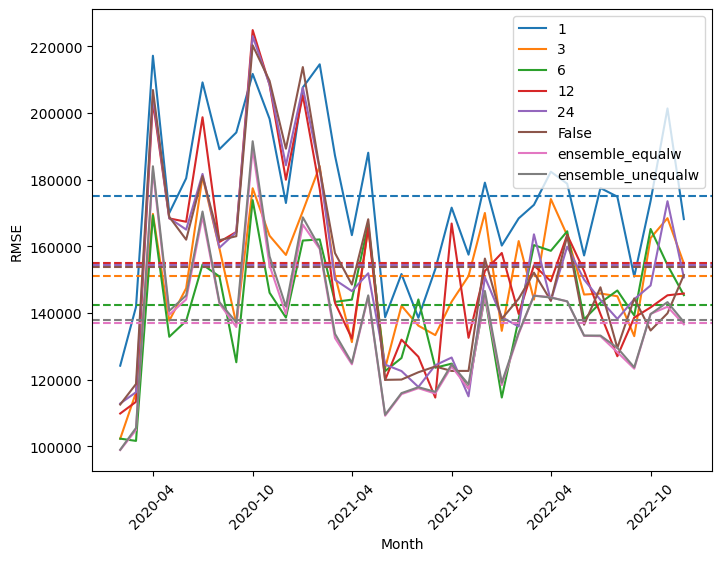

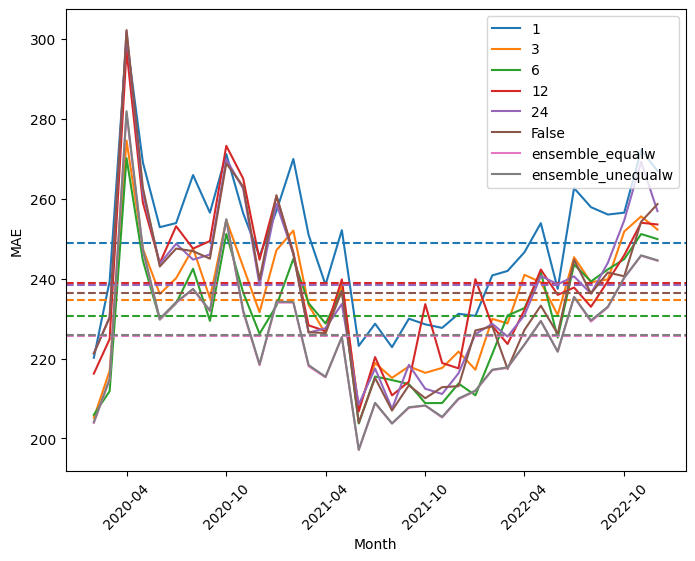

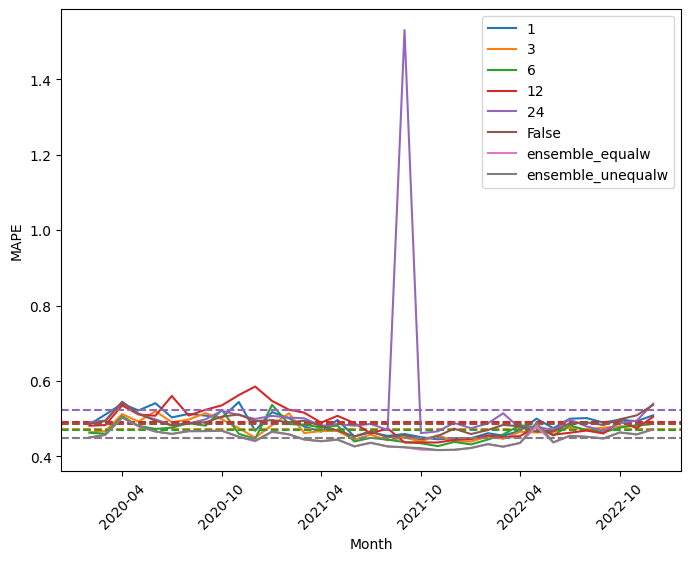

In [36]:
# Plots: experiment 3 (tuning in 2018), plot results for different window sizes + 2 ensembles

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

path_ = r'G:\My Drive\MasterThesis\Output\Tables\EstimationResults\TrainingStage'
w_sizes = [1, 3, 6, 12, 24, False, 'ensemble_equalw', 'ensemble_unequalw']
error_metrics = ['rmse', 'mae', 'mape']

for em in error_metrics:

    # Initialize an empty dictionary to store the data frames with the results
    results_dfs = {}

    for ws in w_sizes:

        # Read df
        res_df = pd.read_csv(path_ + f'\exp3{ws}_notuning.csv', index_col=0)

        # Rename columns
        res_df = res_df.rename(columns={col: f'{col}_exp3{ws}' for col in res_df.columns if col != 'month'})

        # Save into data frame
        results_dfs[f'res_{ws}'] = res_df
        del res_df

    # Merge data frames together
    results = results_dfs['res_1']
    for ws in w_sizes[1:]:

        results = results.merge(results_dfs[f'res_{ws}'], how='left', on=['month'])

    results['month'] = pd.to_datetime(results['month'])
    results = results[results['month'] >= pd.Timestamp('2020-02-01')]
    results.head()

    # Make plot
    plt.figure(figsize=(8, 6))
    ax = plt.gca()

    for ws in w_sizes:
        color = next(ax._get_lines.prop_cycler)['color']
        plt.plot(results['month'], results[str(em)+'_exp3'+str(ws)], label=ws, color=color)
        plt.axhline(y = results[str(em)+'_exp3'+str(ws)].mean(), linestyle = '--', label='', color=color)

    plt.xlabel('Month')
    plt.ylabel(em.upper())
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.legend(loc="upper right")

    # Save plot
    if True:
        path_p = os.path.join(PATH_DATA_OUT, 'Plots', 'EstimationResults', 'TrainingStage', 
                             'Experiment_3', f'{em}_2.png')
        plt.savefig(path_p, dpi=300)  # Save as PNG with high resolution


    plt.show()

In [37]:
# Define functions for test of difference in performance

import numpy as np
# from statsmodels.stats.stattools import durbin_watson
from scipy.stats import norm, t

def newey_west_se(errors, lag):
    """
    Calculate Newey-West standard errors for a series of forecast errors,
    correcting for autocorrelation and heteroskedasticity.

    The lag parameter specifies how many previous periods (lags) the 
    method should consider when adjusting for autocorrelation.

    """
    n = len(errors)
    cov = np.cov(errors, rowvar=False)
    for l in range(1, lag + 1):
        cov_matrix = np.cov(errors[l:], errors[:-l], rowvar=False)
        cov_lagged = cov_matrix[0, 1]
        weight = (lag - l + 1) / (lag + 1)
        cov += weight * 2 * cov_lagged
    return np.sqrt(cov / n)

def diebold_mariano_test(error1, error2, nw=True):
    """
    Perform the Diebold-Mariano test for equal predictive accuracy.
    H0: the mean of the differences between the error from two models is equal to zero
    """
    # Calculate loss differential
    diff = error1 - error2

    # Calculate DM statistic
    mean_diff = np.mean(diff)
    lag = int(np.ceil(4 * (len(diff) / 100) ** (2 / 9))) # Rule-of-thumb for lag length

    # # Durbin-Watson statistic for testing autocorrelation
    # dw_stat = durbin_watson(diff)


    # If diff is autocorrelated, we calculate its SE with the Newey West method
    if nw:
        se = newey_west_se(diff, lag)
    else:
        se = np.sqrt(np.var(diff))

    # Calculate statistic
    dm_stat = mean_diff / se

    # Calculate p-value
    # p_value = 2 * norm.cdf(-abs(dm_stat))
    p_value = 2*t.cdf(-abs(dm_stat), df = float(len(diff)) - 1)

    return dm_stat, p_value

In [38]:
# Tables: experiment 3 (tuning in 2018), create table of relative performance for different window sizes
import numpy as np
import pandas as pd

path_ = r'G:\My Drive\MasterThesis\Output\Tables\EstimationResults\TrainingStage'
w_sizes = [1, 3, 6, 12, 24, 'ensemble_equalw', 'ensemble_unequalw', False]
error_metrics = ['rmse', 'mae', 'mape']

results_table=pd.DataFrame(
        {'window_size': w_sizes[:-1]}
        )

for em in error_metrics:

    # Initialize an empty dictionary to store the data frames with the results
    results_dfs = {}

    for ws in w_sizes:

        # Read df
        res_df = pd.read_csv(path_ + f'\exp3{ws}_notuning.csv', index_col=0)

        # Subset it
        res_df['month'] = pd.to_datetime(res_df['month'])
        res_df = res_df[res_df['month'] >= pd.Timestamp('2020-02-01')]

        # Rename columns
        res_df = res_df.rename(columns={col: f'{col}_exp3{ws}' for col in res_df.columns if col != 'month'})

        # Add to general data frame
        results_dfs[f'res_{ws}'] = res_df
        del res_df

    # Merge data frames together
    results = results_dfs['res_1']
    for ws in w_sizes[1:]:
        results = results.merge(results_dfs[f'res_{ws}'], how='left', on=['month'])

    # Convert date variable to datetime
    results['month'] = pd.to_datetime(results['month'])
    # print(results.head())

    # Subset to relevant period
    starting_month = min(results['month']) + pd.DateOffset(months=max([ws for ws in w_sizes if isinstance(ws, int)]) + 1)
    # print(starting_month)
    results = results.loc[(results['month'] >= starting_month)]
    # print(results.head())

    # Calculate overal mean error p
    # !!! Aca no se si comparar los modelos de acuerdo a la suma de cada metrica de error, o al promedio

    # Calculate the sum of the error for all periods, for each model except the one with all the data
    em_cols = [col for col in results if col.startswith(em) and not col.endswith('False')]
    em_sums = round(results[em_cols].sum() / results[em + '_exp3False'].sum(), 3)
    results_table[em] = np.array(em_sums)

    # Calculate significance of the difference
    dm_stats = []
    p_values = []
    for ws in w_sizes[:-1]:
        error1 = np.array(results_dfs[f'res_{ws}'][f'{em}_exp3{ws}'])
        error2 = np.array(results_dfs['res_False'][f'{em}_exp3False'])

        dm_stat, p_value = diebold_mariano_test(error1, error2, nw=True)
        dm_stats.append(round(dm_stat,3))
        p_values.append(round(p_value,3))
    results_table[f'{em}_dm_stat'] = np.array(dm_stats)
    results_table[f'{em}_dm_pval'] = np.array(p_values)
    
# Save table
path_ = os.path.join(PATH_DATA_OUT, 'Tables', 'EstimationResults', 
                     'TrainingStage', 'all_models_performance_relative_to_False.csv')
results_table.to_csv(path_, index = False, float_format='%.3f')
print(results_table)



         window_size   rmse  rmse_dm_stat  rmse_dm_pval    mae  mae_dm_stat  mae_dm_pval   mape  mape_dm_stat  mape_dm_pval
0                  1  1.204         5.679         0.000  1.072        6.466        0.000  0.998         0.787         0.437
1                  3  1.065        -0.427         0.672  1.018       -0.610        0.546  0.962        -3.845         0.001
2                  6  1.050        -1.603         0.118  1.009       -1.839        0.075  0.966        -4.431         0.000
3                 12  1.010         0.581         0.565  1.007        1.831        0.076  0.961         0.591         0.559
4                 24  1.051         0.359         0.722  1.024        2.089        0.044  1.001         1.248         0.221
5    ensemble_equalw  0.949        -3.846         0.001  0.975       -5.266        0.000  0.924       -14.319         0.000
6  ensemble_unequalw  0.952        -3.804         0.001  0.975       -5.259        0.000  0.926       -13.532         0.000


In [39]:
# Format results table and export as latex
import pandas as pd

path_ = os.path.join(PATH_DATA_OUT, 'Tables', 'EstimationResults', 
                     'TrainingStage', 'all_models_performance_relative_to_False.csv')
tab = pd.read_csv(path_)

# Function to append asterisks based on p-values
def append_asterisks(value, p_value):
    # Format value to ensure three decimal places
    formatted_value = f"{value:.3f}" if not value.is_integer() else f"{value:.1f}00"

    if p_value < 0.01:
        return f"{formatted_value}***"  # 3 asterisks for p < 1%
    elif p_value < 0.05:
        return f"{formatted_value}**"   # 2 asterisks for p < 5%
    elif p_value < 0.10:
        return f"{formatted_value}*"    # 1 asterisk for p < 10%
    else:
        return formatted_value          # No asterisks for p >= 10%

# Apply the function to each row for the error metric columns
for col in ['rmse', 'mae', 'mape']:
    tab[col] = tab.apply(lambda row: append_asterisks(row[col], row[f'{col}_dm_pval']), axis=1)

# Drop columns
tab = tab.drop([x for x in tab if x.endswith('_stat')], axis=1)
tab = tab.drop([x for x in tab if x.endswith('_pval')], axis=1)

# Rename ensemble rows
tab['window_size'][tab['window_size']=='ensemble_equalw'] = 'Ensemble 1'
tab['window_size'][tab['window_size']=='ensemble_unequalw'] = 'Ensemble 2'

# Fix columns
tab.columns = [col_name.upper() for col_name in tab.columns.tolist()]
tab = tab.rename(columns={'WINDOW_SIZE': 'Model by Window Size'})


# Now df has the updated error metric columns
print(tab)

# To LaTeX
ltx = tab.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.3f}".format,)
path_ = os.path.join(PATH_DATA_OUT, 'Tables', 'LaTeX', 'all_models_performance_relative_to_False.txt')
text_file = open(path_, "w")
text_file.write(ltx)
text_file.close()


  Model by Window Size      RMSE       MAE      MAPE
0                    1  1.204***  1.072***     0.998
1                    3     1.065     1.018  0.962***
2                    6     1.050    1.009*  0.966***
3                   12     1.010    1.007*     0.961
4                   24     1.051   1.024**     1.001
5           Ensemble 1  0.949***  0.975***  0.924***
6           Ensemble 2  0.952***  0.975***  0.926***


C:\Users\Usuario\AppData\Local\Temp\ipykernel_21456\1796441259.py:43: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  ltx = tab.to_latex(index=False,
